In [ ]:
# Importing packages
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import ast

# Modifying system path to allow imports from different parts of directory

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(project_root)


In [ ]:
# Loading cleaned 4th down dataset
df_4th = pd.read_csv("C:/Users/jseidl/NFL-4th-Down/data/processed/cleaned_4th_down.csv")

In [ ]:
# Copy of dataframe with went or stay 
df_model = df_4th[df_4th["play_type"].isin(["run", "pass", "punt", "field_goal"])].copy()

# Converting to numeric
df_model["went_for_it"] = df_model["play_type"].isin(["run", "pass"]).astype(int)

In [ ]:
# Feature Engineering

# Creating feature, game time in seconds remaining
df_model["game_seconds_remaining"] = (15 *60 * (4 - df_model["qtr"]))

# Chosen features for model
features = df_model[[
    "ydstogo",
    "yardline_100",
    "score_differential",
    "game_seconds_remaining",
    "qtr",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining"
]].dropna()

labels = df_model.loc[features.index, "went_for_it"]


In [ ]:
# Importing ML packages and DT Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [ ]:
# Training the model

# 75 / 25 split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

# Max depth of 4 to avoid overfitting
model = DecisionTreeClassifier(max_depth=4, random_state=0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
# Save trained model to a pkl file, reuse later without retraining
joblib.dump(model, "tree_model.pkl")

['tree_model.pkl']

In [ ]:
# Viewing metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11288
           1       0.73      0.53      0.62      1980

    accuracy                           0.90     13268
   macro avg       0.82      0.75      0.78     13268
weighted avg       0.89      0.90      0.89     13268



In [ ]:
# Imports for visualization
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

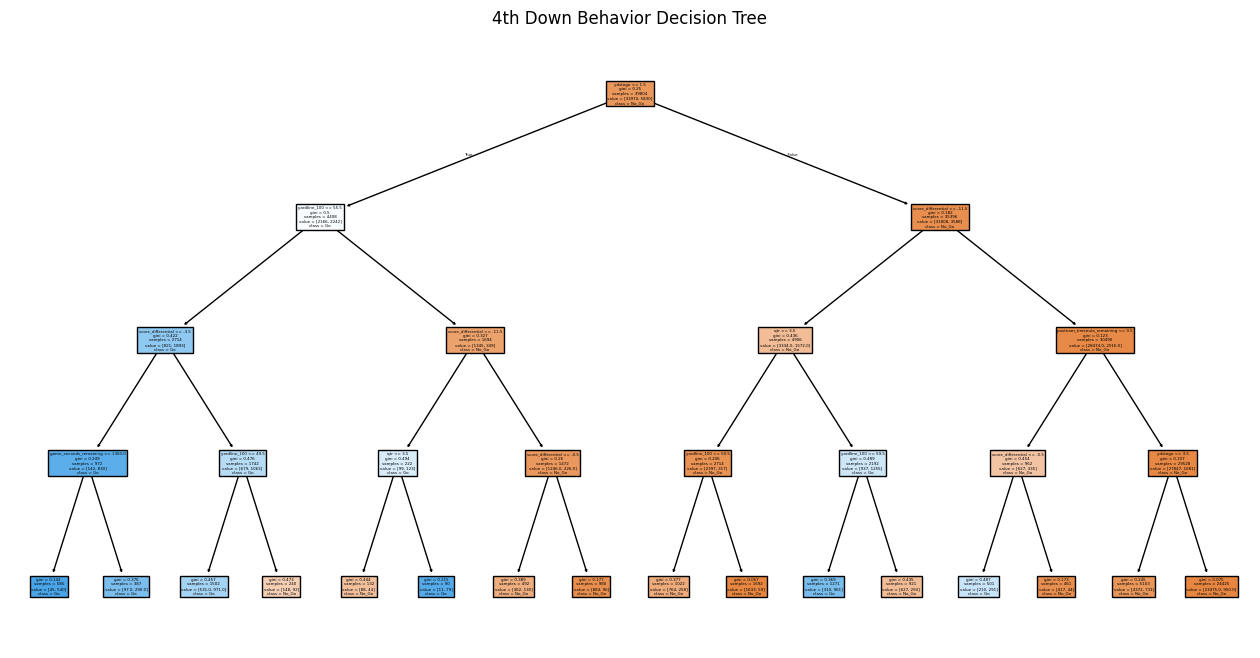

In [ ]:
# Plotting the decision tree
plt.figure(figsize=(16,8))
plot_tree(model, feature_names=features.columns, class_names=["No_Go", "Go"], filled=True)
plt.title("4th Down Behavior Decision Tree")
plt.show()

In [ ]:
# Importing / reading in the decision table
decision_table = pd.read_csv("C:/Users/jseidl/NFL-4th-Down/data/processed/decision_table.csv")

In [12]:
from app.logic.decision_logic import decide_ev_based

In [ ]:
# Converting string from CSV into intervals
# For comparison
def parse_interval(interval_str):
    
    left_bracket = interval_str[0]
    right_bracket = interval_str[-1]
    left_closed = left_bracket == "["
    right_closed = right_bracket == "]"
    
    # Extracting numbers
    bounds = ast.literal_eval(interval_str[1:-1])
    return pd.Interval(bounds[0], bounds[1], 
                       closed=('both' if left_closed and right_closed else 
                               'left' if left_closed else 
                               'right' if right_closed else 
                               'neither'))

# Reapplying to both bin columns using parse interval function 
decision_table["yard_bin"] = decision_table["yard_bin"].apply(parse_interval)
decision_table["distance_bin"] = decision_table["distance_bin"].apply(parse_interval)


In [ ]:
# Compare EV model to actual behavior
# Converting decisions to binary column to compare to coaching behavior

df_model["ev_decision"] = df_model.apply(
    lambda row: decide_ev_based(row["ydstogo"], row["yardline_100"], decision_table), axis=1
)

df_model["ev_go"] = (df_model["ev_decision"] == "Go").astype(int)

# Confusion matrix for model comparison to coach
pd.crosstab(df_model["went_for_it"], df_model["ev_go"], 
            rownames=["Actual (Coach)"], colnames=["Model (EV)"])

Model (EV),0,1
Actual (Coach),,
0,35110,10152
1,3551,4259


In [ ]:
# saving to pkl for future reference
import joblib

joblib.dump(model, "C:/Users/jseidl/NFL-4th-Down/data/tree_model.pkl")

['C:/Users/jseidl/NFL-4th-Down/data/tree_model.pkl']

In [16]:
joblib.dump(features.columns.tolist(), "C:/Users/jseidl/NFL-4th-Down/data/model_features.pkl")

['C:/Users/jseidl/NFL-4th-Down/data/model_features.pkl']